In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 12
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
COL = cols[N % 7]
COL

'Time_on_Gaming'

In [3]:
df = pd.read_csv("../../datasets/teen_phone_addiction_dataset.csv", usecols=[COL])
s = pd.to_numeric(df[COL], errors="coerce").dropna()
df

,Time_on_Gaming
0,1.7
1,4.0
2,1.5
3,1.6
4,0.9
...,...
2995,1.8
2996,0.0
2997,0.2
2998,2.6


In [4]:
s

0       1.7
1       4.0
2       1.5
3       1.6
4       0.9
       ... 
2995    1.8
2996    0.0
2997    0.2
2998    2.6
2999    2.3
Name: Time_on_Gaming, Length: 3000, dtype: float64

In [5]:
###среднее значение###
average = sum(s)/len(s)
print(average)

1.5252666666666597


In [6]:
###дисперсия###
a = np.array(s)
result = np.var(a)
print(round(result,3))

0.87


In [7]:
###мода###
modes = s.mode(dropna=True)
print(modes)

0    0.0
Name: Time_on_Gaming, dtype: float64


In [8]:
counts = df[COL].value_counts()          
dups_counts = counts[counts > 1]           
print(dups_counts)

Time_on_Gaming
0.0    205
1.7    140
1.6    131
1.2    130
1.0    122
1.4    122
1.5    120
1.3    120
1.8    110
1.9    103
2.1     95
1.1     93
2.3     92
2.0     92
0.9     90
0.7     89
2.2     88
0.6     83
0.8     82
2.4     76
2.5     75
0.5     67
2.6     65
0.4     65
0.3     62
0.2     59
2.7     54
0.1     52
2.9     50
3.1     48
2.8     42
3.0     36
3.2     29
3.3     26
4.0     25
3.4     16
3.6     15
3.7     12
3.5     10
3.8      7
3.9      2
Name: count, dtype: int64


In [9]:
###медиана###
med = np.median(s)
print(med)

1.5


In [10]:
###Квантили уровня 0.25, 0.5, 0.75###
quantiles = np.quantile(s, [0.25, 0.5, 0.75])
print(f"Квантили (0.25, 0.5, 0.75): {quantiles}")

Квантили (0.25, 0.5, 0.75): [0.8 1.5 2.2]


In [11]:
###Эксцесс###
df.kurtosis()

Time_on_Gaming   -0.498206
dtype: float64

In [12]:
###Ассиметрия###
skew = s.skew()
print(skew)

0.2590108181356894


In [13]:
###Интерквартильный размах###
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
print(iqr)

1.4000000000000001


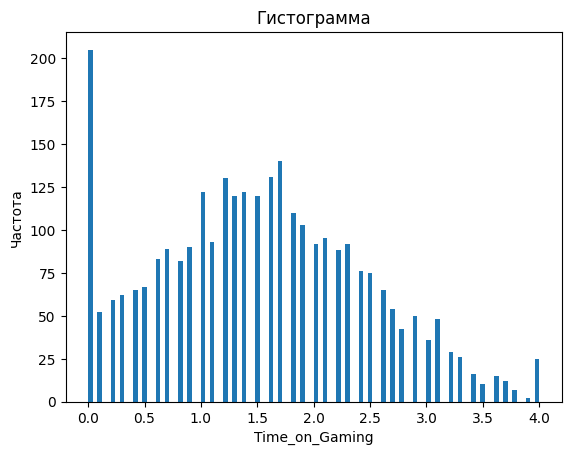

In [ ]:
plt.figure()
plt.hist(s, bins=100)        
plt.xlabel(COL)
plt.ylabel("Частота")
plt.title("Гистограмма")
plt.show()

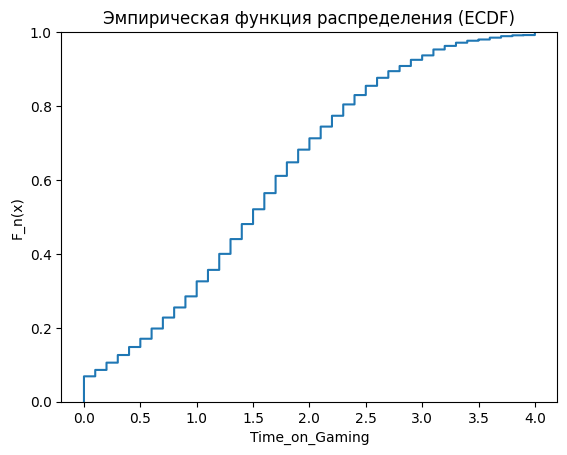

In [15]:
x = np.sort(s.to_numpy())
n = x.size
y = np.arange(1, n + 1) / n       

plt.figure()
plt.step(x, y, where="post")
plt.xlabel(COL)
plt.ylabel("F_n(x)")
plt.title("Эмпирическая функция распределения (ECDF)")
plt.ylim(0, 1)
plt.show()

In [16]:
from math import erf, sqrt

def norm_cdf(x, mu, sigma):
    return 0.5 * (1 + erf((x - mu) / (sigma * sqrt(2))))

def chi2_normality(series, bins=10):
    n = len(series)
    mu = series.mean()
    sigma = series.std(ddof=0) 
    
    binned = pd.cut(series, bins=bins, include_lowest=True)
    observed = binned.value_counts().sort_index().values
    
    edges = binned.cat.categories
    expected = []
    
    for interval in edges:
        left = -np.inf if pd.isna(interval.left) else interval.left
        right = np.inf if pd.isna(interval.right) else interval.right
        
        p_left = 0 if np.isinf(left) else norm_cdf(left, mu, sigma)
        p_right = 1 if np.isinf(right) else norm_cdf(right, mu, sigma)
        
        prob = p_right - p_left
        expected.append(n * prob)
    
    expected = np.array(expected)
    observed = np.array(observed)

    mask = expected > 0
    observed = observed[mask]
    expected = expected[mask]
    
    chi2 = ((observed - expected) ** 2 / expected).sum()
    df = len(observed) - 1 - 2 
    return chi2, df

In [17]:
chi2, df = chi2_normality(s, bins=10)
print(f"Хи-квадрат: {chi2:.2f}")
print(f"Степени свободы: {df}")

Хи-квадрат: 362.81
Степени свободы: 7


In [18]:
import pandas as pd
from math import sqrt, erfc, exp

def normality_skew_kurtosis(df, alpha=0.05):
    rows = []
    for c in df.select_dtypes(include='number').columns:
        x = df[c].dropna()
        n = len(x)
        s = x.skew()
        k = x.kurt()
        ps = erfc(abs(s * sqrt(n / 6)) / sqrt(2))
        pk = erfc(abs(k * sqrt(n / 24)) / sqrt(2))
        rows.append([c, s, k, ps, pk, ps > alpha and pk > alpha])
    return pd.DataFrame(rows, columns=['column','skew','excess_kurtosis','p_skew','p_kurt','normal']).set_index('column')
normality_skew_kurtosis(pd.DataFrame(s))

,skew,excess_kurtosis,p_skew,p_kurt,normal
column,,,,,
Time_on_Gaming,0.259011,-0.498206,6.969497e-09,2.545692e-08,False


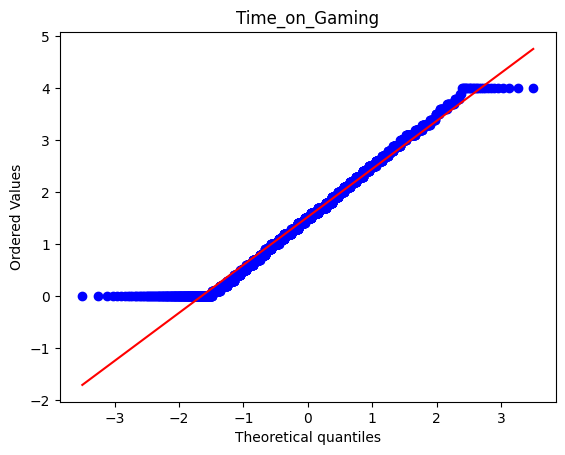

In [19]:
import matplotlib.pyplot as plt
from scipy import stats

def qqplot(df):
    for c in df.select_dtypes(include='number').columns:
        plt.figure()
        stats.probplot(df[c].dropna(), dist='norm', plot=plt)
        plt.title(c)
    plt.show()
qqplot(pd.DataFrame(s))

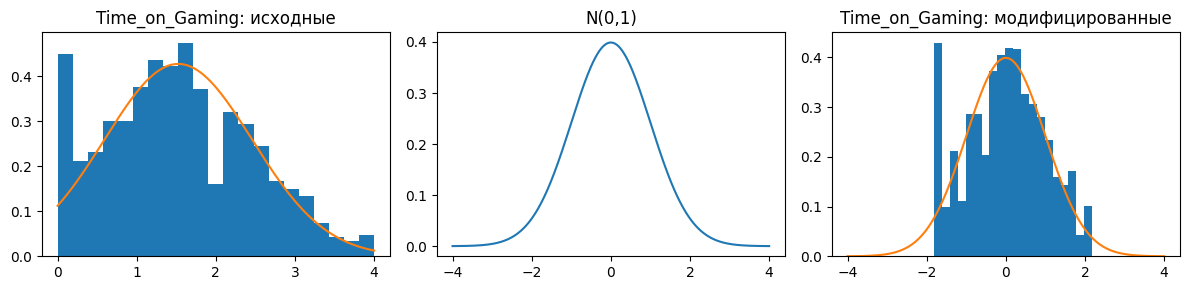

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def make_normal(df):
    out = {}
    for c in df.select_dtypes(include='number').columns:
        x = df[c].dropna()
        ql, qu = x.quantile(0.01), x.quantile(0.99)
        x = x.clip(ql, qu)
        if (x > 0).all():
            y = np.log1p(x)
        else:
            y = pd.Series(stats.yeojohnson(x.to_numpy())[0], index=x.index)
        z = (y - y.mean()) / y.std()
        out[c] = z.reindex(df.index)
    return pd.DataFrame(out, index=df.index)

def plot_distributions(df):
    df2 = make_normal(df)
    for c in df.select_dtypes(include='number').columns:
        x = df[c].dropna()
        mu, sg = x.mean(), x.std()
        xs = np.linspace(x.min(), x.max(), 200)
        t = df2[c].dropna()
        z = np.linspace(-4, 4, 400)
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        ax[0].hist(x, bins='auto', density=True)
        ax[0].plot(xs, stats.norm.pdf(xs, mu, sg))
        ax[0].set_title(f'{c}: исходные')
        ax[1].plot(z, stats.norm.pdf(z))
        ax[1].set_title('N(0,1)')
        ax[2].hist(t, bins='auto', density=True)
        ax[2].plot(z, stats.norm.pdf(z))
        ax[2].set_title(f'{c}: модифицированные')
        plt.tight_layout()
    plt.show()


plot_distributions(pd.DataFrame(s))

In [21]:
df = make_normal(pd.DataFrame(s))
s = df.Time_on_Gaming

2.6249373045554116e-16
1.0
0   -1.813542
Name: Time_on_Gaming, dtype: float64
Time_on_Gaming
-1.813542    205
 0.257894    140
 0.153929    131
-0.278360    130
-0.058743    122
-0.505814    122
 0.048412    120
-0.167632    120
 0.360386    110
 0.461478    103
 0.659723     95
-0.391044     93
 0.853099     92
 0.561237     92
-0.622817     90
-0.864199     89
 0.756993     88
-0.988978     83
-0.742216     82
 0.948090     76
 1.042011     75
-1.116799     67
 1.134904     65
-1.247947     65
-1.382755     62
-1.521622     59
 1.226809     54
-1.665023     52
 1.407798     50
 1.585247     48
 1.317762     42
 1.496950     36
 2.181631     34
 1.672718     29
 1.759391     26
 1.845292     16
 2.014870     15
 2.098592     12
 1.930444     10
Name: count, dtype: int64
0.048411818811610975
Квантили (0.25, 0.5, 0.75): [-0.74221589  0.04841182  0.75699274]
Time_on_Gaming   -0.680888
dtype: float64
-0.062251998792357766
1.4992086225845989


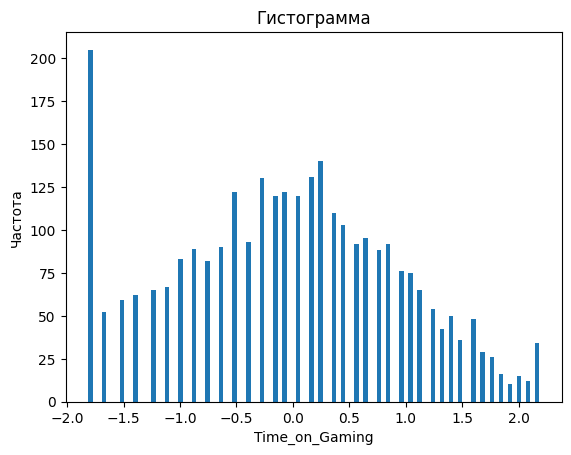

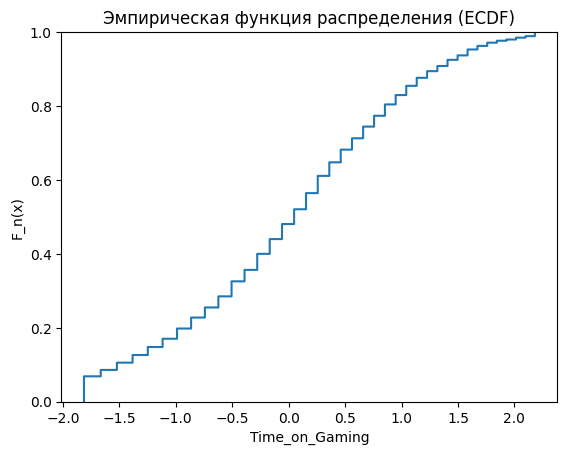

In [ ]:
###среднее значение###
average = sum(s)/len(s)
print(average)
###дисперсия###
a = np.array(s)
result = np.var(a)
print(round(result,3))
###мода###
modes = s.mode(dropna=True)
print(modes)
counts = df[COL].value_counts()          
dups_counts = counts[counts > 1]           
print(dups_counts)
###медиана###
med = np.median(s)
print(med)
###Квантили уровня 0.25, 0.5, 0.75###
quantiles = np.quantile(s, [0.25, 0.5, 0.75])
print(f"Квантили (0.25, 0.5, 0.75): {quantiles}")
###Эксцесс###
print(df.kurtosis())
###Ассиметрия###
skew = s.skew()
print(skew)
###Интерквартильный размах###
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
print(iqr)
plt.figure()
plt.hist(s, bins=100)
plt.xlabel(COL)
plt.ylabel("Частота")
plt.title("Гистограмма")
plt.show()
x = np.sort(s.to_numpy())
n = x.size
y = np.arange(1, n + 1) / n       

plt.figure()
plt.step(x, y, where="post")
plt.xlabel(COL)
plt.ylabel("F_n(x)")
plt.title("Эмпирическая функция распределения (ECDF)")
plt.ylim(0, 1)
plt.show()

In [25]:
df = pd.read_csv("../../datasets/teen_phone_addiction_dataset.csv")
df = df[['School_Grade',COL]]
df

,School_Grade,Time_on_Gaming
0,9th,1.7
1,7th,4.0
2,11th,1.5
3,12th,1.6
4,9th,0.9
...,...,...
2995,12th,1.8
2996,8th,0.0
2997,7th,0.2
2998,9th,2.6


In [26]:
df.groupby('School_Grade').describe()

Time_on_Gaming                                             
                      count      mean       std  min  25%  50%  75%  max
School_Grade                                                            
10th                  487.0  1.453183  0.928108  0.0  0.8  1.4  2.1  4.0
11th                  479.0  1.512317  0.887474  0.0  0.8  1.5  2.1  4.0
12th                  529.0  1.520227  0.971520  0.0  0.8  1.5  2.2  4.0
7th                   497.0  1.554125  0.881295  0.0  0.9  1.6  2.2  4.0
8th                   482.0  1.538589  0.982320  0.0  0.8  1.5  2.2  4.0
9th                   526.0  1.569392  0.938019  0.0  0.9  1.5  2.2  4.0

In [27]:
df.groupby('School_Grade').var()

,Time_on_Gaming
School_Grade,
10th,0.861384
11th,0.787609
12th,0.943851
7th,0.776682
8th,0.964953
9th,0.879880


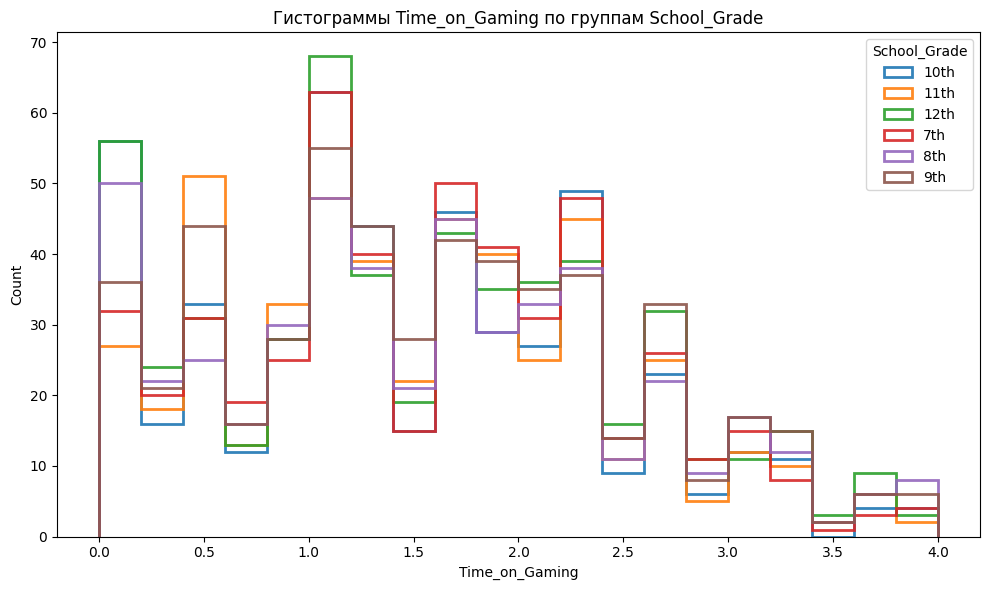

In [32]:
import numpy as np
import matplotlib.pyplot as plt

group_col = 'School_Grade'
value_col = 'Time_on_Gaming'

data = df[[group_col, value_col]].dropna()

_, bin_edges = np.histogram(data[value_col], bins=20)

plt.figure(figsize=(10, 6))

for name, sub in data.groupby(group_col):
    plt.hist(
        sub[value_col],
        bins=bin_edges,
        histtype='step',   
        linewidth=2,
        alpha=0.9,
        label=str(name),
        density=False    
    )

plt.legend(title=group_col)
plt.xlabel(value_col)
plt.ylabel('Count')  # или 'Density' если density=True
plt.title(f'Гистограммы {value_col} по группам {group_col}')
plt.tight_layout()
plt.show()
